In [1]:
import scipy.integrate as integrate
import scipy.special as special
from numpy import sqrt, exp, pi, log
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
from pydtmc import MarkovChain
import seaborn as sns
from scipy.linalg import expm
np.random.seed(42)
plt.style.use("dark_background")

In [2]:
def TVaR(arr,a):
    edge = np.array(sorted(arr)[int(a*len(arr)):])
    return edge.mean()

In [3]:
mu = 0.5
nu = 0.5
r_b = 0.03
alpha_b = np.array([0.02, 0.07])
sigma_b = np.array([0.10, 0.3])

pi_1 = pi_2 = 0.5
t = 0
T = 10
h = 1/12
inf = 0.02

## Expense Assumptions
ED_b = 15
ES_b = 15
EIF_b = 75
commish = 0.05

## Guarantee Conditions
F0 = 100000
GMMB = F0 * 1.2
fee = [0.028165,0.033103]
PARAMS = {0:[0.03,np.array([1,1]),1,1,1], 1:[0.01,np.array([1.1,1.1]),1,1,1],
          2:[0.06,np.array([0.9,0.9]),1,1,1],3:[0.03,np.array([1.2,0.8]),1,1,1],
          4:[0.03,np.array([1,1]),1.1,1,1],5:[0.03,np.array([1,1]),1,1.1,1],
          6:[0.03,np.array([1,1]),1,1,1.1],7:[0.01,np.array([1.1,1.1]),1.1,1.1,1.1]}
beta = 0
GMDB = 1.1*F0

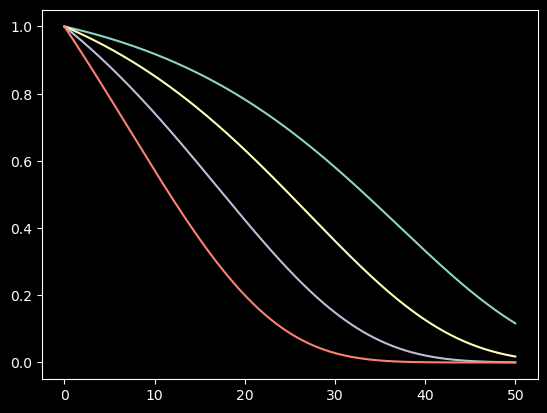

In [4]:
## Mortality Modeling

A_b = 0.0001
B_b = 0.00026
c_b = 1.065
A = A_b
B = B_b
c = c_b
def mort(x):
    return A + B*pow(c,x)
def p(t,x):
    F = B*pow(c,x)/log(c)
    return exp(-(A*t + F*(pow(c,t)-1)))

plt.plot([t/100 for t in range(0,5000)],[p(t/100,50) for t in range(0,5000)])
plt.plot([t/100 for t in range(0,5000)],[p(t/100,60) for t in range(0,5000)])
plt.plot([t/100 for t in range(0,5000)],[p(t/100,70) for t in range(0,5000)])
plt.plot([t/100 for t in range(0,5000)],[p(t/100,80) for t in range(0,5000)])
plt.show()

In [5]:
def e(x):
    E = 0
    for t in range(int(120-x)):
        E += p(t,x)
    return E
np.array([e(0),e(50),e(60),e(70)]).round(2)

array([78.57, 32.92, 25.32, 18.68])

In [6]:
## Surrender Modeling

def surrender(surr_factor, t):
    
    if t <= 1:
        return [0.0050*surr_factor, 0.90]
    elif t <= 2:
        return [0.0100*surr_factor, 0.92]
    elif t <= 3:
        return [0.0150*surr_factor, 0.94]
    elif t <= 4:
        return [0.0150*surr_factor, 0.96]
    
    ## Surrender Ends
    
    elif t <= 5:
        return [0.3000*surr_factor, 1.00]
    
    elif t <= 6:
        return [0.1500*surr_factor, 1.00]
    elif t <= 7:
        return [0.1000*surr_factor, 1.00]
    elif t <= 8:
        return [0.0750*surr_factor, 1.00]
    elif t <= 9:
        return [0.0700*surr_factor, 1.00]
    elif t <= 10:
        return [0.0600*surr_factor, 1.00]
    else:
        return [0.0450*surr_factor, 1.00]

In [7]:
mu = 0.5
nu = 0.5
Tr_Mat = [[-mu,mu],
          [nu,-nu]]
P = expm(Tr_Mat)
p12 = exp(-mu*h)
p21 = exp(-nu*h)
## Initial Probabilities
pi_1 = p21 / (p12 + p21)
pi_2 = p12 / (p12 + p21)
pi_1,pi_2
mc = MarkovChain(P,["0","1"])
P

array([[0.68393972, 0.31606028],
       [0.31606028, 0.68393972]])

In [8]:
np.random.seed(17)
LIABILITIES_ALL_SCENARIOS = []
for s in range(len(PARAMS.keys())):
    ## Creating market sample paths
    T = 10
    h = 1/12
    M = int(T/h) ## Length of sims
    N = 1000 ## Number of sims
    P = 500
    regime_states = [mc.simulate(steps=M) for n in range(N)] ## len M + 1

    variates = [norm.rvs(size=M+1) for n in range(N)]

    LIABILITIES = []

    FUNDS = []

    for n in range(N):
        r = r_b*PARAMS[s][0]
        alpha = alpha_b*PARAMS[s][1]
        sigma = sigma_b*PARAMS[s][1]
        A = A_b*PARAMS[s][3]
        B = B_b*PARAMS[s][3]
        c = c_b
        ED = ED_b*PARAMS[s][4]
        ES = ES_b*PARAMS[s][4]
        EIF = EIF_b*PARAMS[s][4]
        ## initial age of policyholders
        ph_ages = np.random.normal(67.5,2,size=P)

        Liab = commish*F0*len(ph_ages)

        liability_over_time = [Liab]

        F = F0

        fund_value = [F]

        for k in range(M+1):
            ## Market Model
            if regime_states[n][k] == "0":
                f = exp((alpha[0]-fee[0]-0.5*sigma[0]**2)*h+sigma[0]*h*variates[n][k])
                F *= f
                fund_value.append(F)
            else:
                f = exp((alpha[1]-fee[0]-0.5*sigma[1]**2)*h+sigma[1]*h*variates[n][k])
                F *= f
                fund_value.append(F)

            ## who died?
            grim_reaper = [np.random.random() > p(h,x) for x in ph_ages]
            ## who left
            white_flag = [np.random.random() < surrender(PARAMS[s][2],k*h)[0]*h for x in ph_ages]
            
            new_ph = []
            for i in range(len(ph_ages)):
                if not (grim_reaper[i] or white_flag[i]):
                    new_ph.append(ph_ages[i])
            ph_ages = np.array(new_ph)
            ## update liability
            Liab += exp(-r*(T - k*h))*(GMDB*exp(beta*k*h)+ ED *h* exp(inf*k*h))*sum(grim_reaper)
            Liab += exp(-r*(T - k*h))*(F*surrender(PARAMS[s][2], k*h)[1] + ES *h* exp(inf*k*h))*sum(np.delete(white_flag,grim_reaper))  ## filter out dead & surrendered
            Liab += exp(-r*(T - k*h))*(EIF *h* exp(inf*k*h) * len(ph_ages))
            liability_over_time.append(Liab)

            ph_ages = ph_ages + h
            ## update policyholder list
        liability_over_time = np.array(liability_over_time)
        liability_over_time[-1] += max(GMMB,F)*len(ph_ages)

        LIABILITIES.append(liability_over_time[-1])
    LIABILITIES_ALL_SCENARIOS.append(LIABILITIES)

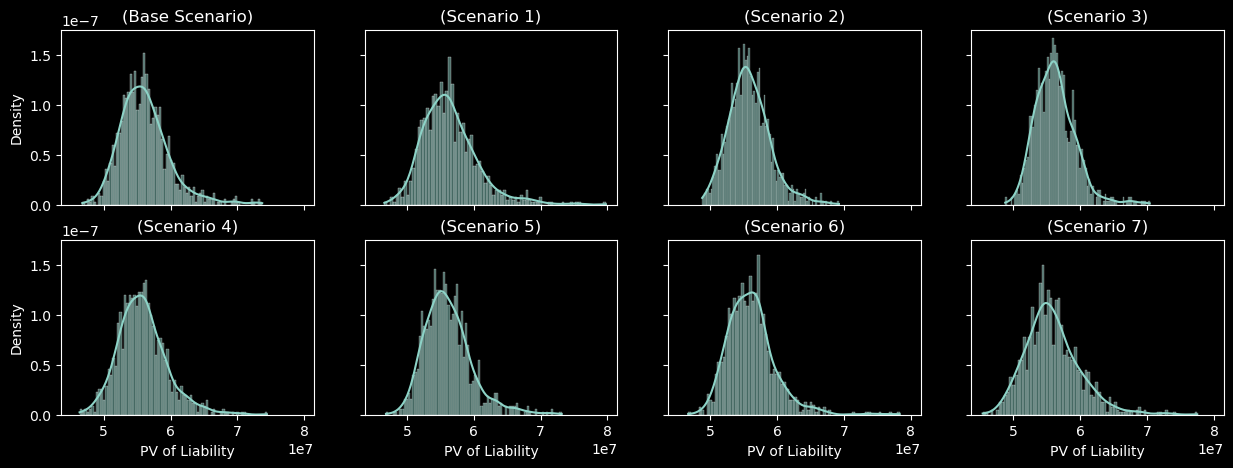

In [9]:
K = 80
m = {0:[0,0],1:[0,1],2:[0,2],3:[0,3],4:[1,0],5:[1,1],6:[1,2],7:[1,3]}
fig, ax1 = plt.subplots(2,4,sharey=True,sharex = True)
fig.set_figheight(5)
fig.set_figwidth(15)
#ax1.set_title("Distribution of Simulated Present Value of Liabilities")
sns.histplot(sorted(np.array(LIABILITIES_ALL_SCENARIOS[0]))[:-2], bins=K, ax = ax1[m[0][0]][m[0][1]], kde=True,stat="density")
ax1[m[0][0]][m[0][1]].set_title('(Base Scenario)', color="white")
ax1[m[0][0]][m[0][1]].set_xlabel("PV of Liability",c="white")
for s in range(1,len(LIABILITIES_ALL_SCENARIOS)):
    sns.histplot(sorted(np.array(LIABILITIES_ALL_SCENARIOS[s]))[:-2], bins=K, ax = ax1[m[s][0]][m[s][1]],kde=True,stat="density")
    ax1[m[s][0]][m[s][1]].set_title('(Scenario ' + str(s) + ")", color="white")
    ax1[m[s][0]][m[s][1]].set_xlabel("PV of Liability",c="white")

plt.show()

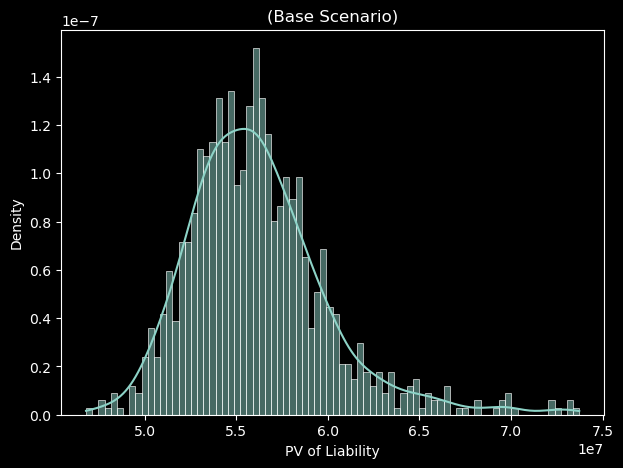

56203943.07537602

In [13]:
K = 80
m = {0:[0,0],1:[0,1],2:[0,2],3:[0,3],4:[1,0],5:[1,1],6:[1,2],7:[1,3]}
fig, ax1 = plt.subplots(1,1,sharey=True,sharex = True)
fig.set_figheight(5)
fig.set_figwidth(7)
#ax1.set_title("Distribution of Simulated Present Value of Liabilities")
sns.histplot(sorted(np.array(LIABILITIES_ALL_SCENARIOS[0]))[:-2], bins=K, ax = ax1, kde=True,stat="density")
ax1.set_title('(Base Scenario)', color="white")
ax1.set_xlabel("PV of Liability",c="white")

plt.show()
np.array(LIABILITIES_ALL_SCENARIOS[0]).mean()

In [14]:
A1 = 51914115.87248703 ## Taking value from other notebook for 2RS model average in computation of change to average
Q = [0.90, 0.95, 0.99]
a1 = np.array(LIABILITIES_ALL_SCENARIOS)
for q in Q:
    print(q, "Scenarios 1 to 7")
    for a in a1[1:]:
        print(np.array([TVaR(a,q) / a.mean(), np.quantile(a,q)/a1.mean(), a.mean() - A1]).round(2))

0.9 Scenarios 1 to 7
[1.16000000e+00 1.09000000e+00 4.52681112e+06]
[1.11000000e+00 1.06000000e+00 3.98383835e+06]
[1.11000000e+00 1.07000000e+00 4.37457865e+06]
[1.14000000e+00 1.08000000e+00 3.92673317e+06]
[1.14000000e+00 1.08000000e+00 4.29363398e+06]
[1.14000000e+00 1.08000000e+00 4.26007824e+06]
[1.15000000e+00 1.09000000e+00 3.98074784e+06]
0.95 Scenarios 1 to 7
[1.21000000e+00 1.14000000e+00 4.52681112e+06]
[1.15000000e+00 1.09000000e+00 3.98383835e+06]
[1.15000000e+00 1.09000000e+00 4.37457865e+06]
[1.18000000e+00 1.11000000e+00 3.92673317e+06]
[1.18000000e+00 1.12000000e+00 4.29363398e+06]
[1.18000000e+00 1.11000000e+00 4.26007824e+06]
[1.20000000e+00 1.12000000e+00 3.98074784e+06]
0.99 Scenarios 1 to 7
[1.33000000e+00 1.25000000e+00 4.52681112e+06]
[1.22000000e+00 1.17000000e+00 3.98383835e+06]
[1.23000000e+00 1.20000000e+00 4.37457865e+06]
[1.27000000e+00 1.21000000e+00 3.92673317e+06]
[1.28000000e+00 1.21000000e+00 4.29363398e+06]
[1.33000000e+00 1.20000000e+00 4.26007824e